In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [1]:
#%matplotlib inline
#%matplotlib gtk
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
#import fconcrete
#from fconcrete import helpers, duplicated, Material, e, Beam, Node, Loads, Nodes, Load,Material, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section, ConcreteSteels
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
#from math import log

# Tension in MPa
# length in cm
# Shear in kN

In [3]:
material = fc.Concrete(fck='30 MPa', aggressiveness=2)
section = fc.Rectangle(25,56, material)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.SingleBeamElement([n1, n2], section)
bar2 = fc.SingleBeamElement([n2, n3], section)
bar3 = fc.SingleBeamElement([n3, n4], section)

fc.config.available_material = {
    "concrete_long_steel_bars":fc.AvailableLongConcreteSteelBar(diameters=[8]),
    "concrete_transv_steel_bars":fc.AvailableTransvConcreteSteelBar(diameters=[8]),
}
    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 2,
)
self = beam
steel_bars = self.steel_bars

In [20]:
class TransvSteelBarSolve():
    def __init__(self, concrete_beam, fyk=50, theta_in_degree=45, alpha_in_degree = 90):
        self.available = fc.config.available_material["concrete_transv_steel_bars"]
        self.concrete_beam = concrete_beam
        x, shear_diagram = concrete_beam.getShearDesignDiagram(division=concrete_beam.division)
        self.x = x
        self.shear_diagram = abs(shear_diagram)
        self.fyk = fyk
        self.fyd = fyk/1.4
        self.theta = (theta_in_degree*pi)/180
        self.alpha = (alpha_in_degree*pi)/180
        v_rd2, d, v_sd = self.checkProbableCompressedConnectingRod()
        self.s_max = self._getS_max(v_rd2, d, v_sd, self.available)
        self.shear_area_per_cm = self.getShearSteelAreaPerCmDiagram()
        self.transv_steel_bars = self.getStirrupsInfo()
    
    @staticmethod
    def _getS_max(v_rd2, d, v_sd, available):
        s_max = min(0.6*d, 30) if v_sd <= 0.67*v_rd2 else min(0.3*d, 20)        
        return s_max
        
    def checkProbableCompressedConnectingRod(self):
        max_shear = max(self.shear_diagram)
        max_shear_x = self.x[self.shear_diagram == max_shear][0]
        max_section = beam.getSingleBeamElementInX(max_shear_x)[1].section
        v_rd2 = self.getV_rd2(max_section)
        check = max_shear <= v_rd2
        if check == False: raise Exception("Shear ({}kN) in x={} is greater or equal to maximum shear allowed ({}kN)".format(max_shear, max_shear_x, v_rd2))
        return v_rd2, max_section.d, max_shear
    
    def getV_rd2(self, section):
        fck = section.material.fck
        bw = section.bw
        d = section.d
        fcd = section.material.fcd
        alpha_v2 = (1-fck/25)
        v_rd2 = 0.54*alpha_v2*fcd*bw*d*(sin(self.theta))*(tan(self.alpha)**(-1)+tan(self.theta)**(-1))
        return v_rd2
    
    def getMinimumSteelAreaPerCm(self,section):
        fctm = section.material.fctm
        bw = section.bw
        As_per_cm_min = 0.2*fctm*bw*sin(self.alpha)/self.fyk
        return As_per_cm_min
    

    def getShearSteelAreaPerCm(self, x, v_sd): 
        # can be optimized
        section = self.concrete_beam.getSingleBeamElementInX(x)[1].section
        v_rd2 = self.getV_rd2(section)
        As_per_cm_min = self.getMinimumSteelAreaPerCm(section)
        
        _, single_beam_element = self.concrete_beam.getSingleBeamElementInX(x)
        bw = single_beam_element.section.bw
        d = single_beam_element.section.d
        fctd = single_beam_element.section.material.fctd

        v_c0 = 0.6*fctd*bw*d
        v_c1 = np.interp(v_sd, [v_c0, v_c0, v_rd2], [v_c0, v_c0, 0])
        v_c = v_c1
        v_sw = max(v_sd - v_c, 0)
        
        As_per_cm = v_sw/(0.9*d*self.fyd*(sin(self.alpha))*(tan(self.alpha)**(-1)+tan(self.theta)**(-1)))
        
        return max(As_per_cm, As_per_cm_min)

    def getShearSteelAreaPerCmDiagram(self):
        shear_area_per_cm = [self.getShearSteelAreaPerCm(x_u, v_sd) for x_u, v_sd in zip(self.x, self.shear_diagram)]
        return np.array(shear_area_per_cm)
    
    def getComercialInfo(self, as_per_cm):
        table = self.available.table
        diameter, space, area, as_per_cm = table[table[:, 3] >= as_per_cm][0]
        return diameter, space, area, as_per_cm
    
    def getStirrupsInfo(self):
        x_array, shear_area_per_cm = self.x, self.shear_area_per_cm
        s_max = self.s_max
        x = beam.x_begin
        transversal_steel = TransvSteelBars()

        while x<beam.x_end:
            x_loop = ((x_array>x) & (x_array<x+s_max))
            shear = max(abs(shear_area_per_cm[x_loop]))
            diameter, space, area, as_per_cm = self.getComercialInfo(shear)
            single_beam_element = self.concrete_beam.getSingleBeamElementInX(x)[1]
            height = single_beam_element.section.height
            width = single_beam_element.section.width()
            c = single_beam_element.section.material.c
            transversal_steel.add(
                fc.TransvSteelBar(x, height-2*c, width-2*c, diameter, space, area, as_per_cm)
            )
            x += space
            
        return transversal_steel

    def plot(self):
        for x, height in zip(self.transv_steel_bars.x, self.transv_steel_bars.heights):
            plt.plot([x,x], [0,height])

In [21]:
trans_bar = TransvSteelBarSolve(
    concrete_beam=beam,
    fyk=50,
    theta_in_degree = 45,
    alpha_in_degree = 90
)


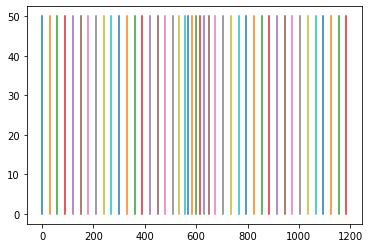

In [22]:
trans_bar.plot()

In [121]:
class TransvSteelBar():
    def __init__(self, x, height, width, diameter, space_after, area, as_per_cm):
        self.x = x
        self.height = height
        self.width = width
        self.diameter = diameter
        self.space_after = space_after
        self.area = area
        self.as_per_cm = as_per_cm
    

    

In [6]:
str(type(fc.TransvSteelBar(1,2,3,4,5,6,7)))

"<class 'fconcrete.TransvSteelBar.TransvSteelBar.TransvSteelBar'>"

In [123]:
a = TransvSteelBars()

In [7]:
class TransvSteelBars():
    def __init__(self, steel_bars=[]):
        self.steel_bars = np.array(steel_bars)
        self.x = np.array([ steel_bar.x for steel_bar in self.steel_bars ])
        self.heights = np.array([ steel_bar.height for steel_bar in self.steel_bars ])
        self.widths = np.array([ steel_bar.width for steel_bar in self.steel_bars ])
        self.diameters = np.array([ steel_bar.diameter for steel_bar in self.steel_bars ])
        self.space_afters = np.array([ steel_bar.space_after for steel_bar in self.steel_bars ])
        self.areas = np.array([ steel_bar.area for steel_bar in self.steel_bars ])
        self.as_per_cms = np.array([ steel_bar.as_per_cm for steel_bar in self.steel_bars ])
    
    def add(self, new_steel_bars):
        previous_steel_bars = self.steel_bars
        if str(type(new_steel_bars)) == "<class 'fconcrete.TransvSteelBar.TransvSteelBar.TransvSteelBars'>":
            concatenation = list(np.concatenate((previous_steel_bars,new_steel_bars.steel_bars)))
            concatenation.sort(key=lambda x: x.long_begin, reverse=False)
            new_steel_bars = np.array(concatenation)
            
        elif str(type(new_steel_bars)) == "<class 'fconcrete.TransvSteelBar.TransvSteelBar.TransvSteelBar'>":
            new_steel_bars = np.append(previous_steel_bars,new_steel_bars)
        self.__init__(new_steel_bars)
    
    def changeProperty(self, prop, function, conditional=lambda x:True):
        steel_bars = copy.deepcopy(self)
        for previous_steel_bar in steel_bars:
            if conditional(previous_steel_bar):
                current_attribute_value = getattr(previous_steel_bar, prop)
                setattr(previous_steel_bar, prop, function(current_attribute_value)) 
        return steel_bars

    def plotLong(self):
        x_stirrups = self.x
        height_stirrups = self.heights
        for x, height in zip(x_stirrups, height_stirrups):
            plt.plot([x,x], [0,height])
            
    def __getitem__(self, key):
        return self.steel_bars[key]
    
    def __repr__(self):
        return str(self.steel_bars)

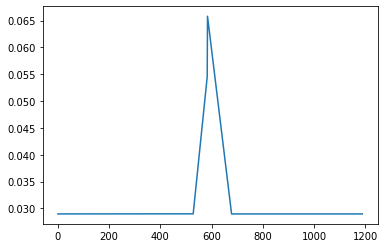

In [100]:
x = trans_bar.x
shear_area_per_cm = trans_bar.shear_area_per_cm
plt.plot(x, shear_area_per_cm)

In [77]:
a, b, c = [1, 2, 3]

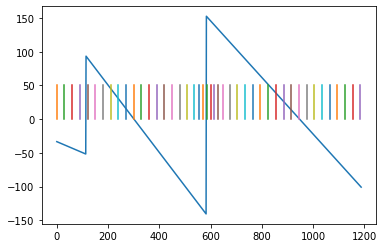

In [106]:
beam.plotShearDiagram()
trans_bar.plot()

### Decaleged Behaviour

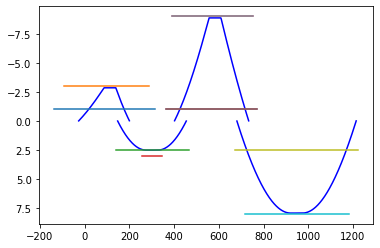

In [3]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, yn, 'b-')
self.steel_bars.plot()